# 4. Computing Dynamic Gradients

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

/Users/michaelc.c.h/opt/miniconda3/envs/brain2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.ndimage import gaussian_filter

## Description

We investigate the dynamic gradients connectivity for single acquisitions. (i.e we process at individual level) Looking at aligned gradient's centroid and concentration

GOAL: Visualize over time topology change of connectivity gradients and analysing region clusters' shifts and concentration

### Standard Sliding window Dynamic
In literature, for dynamic windows, it is usually recommended to have over 30 TR in one window. Now however empirically we do not have stability in the case and will therefore as well look into longer TR windows.

## Table of Contents
Individual Dynamics
- [Standard Sliding window Dynamic (Individual)](#individual)

Group Level Dynamics
- [Standard Sliding window Dynamic (Group)](#group)

Quick Test
- [Sliding window Size against explained variance (Investigate)](#windowsize)

Display
- ["Non-dynamic" display of dynamic gradient plot](#visualization)


In [6]:
# mri_path = "./data/fmri400_compiled/"
mri_path = "./data/fmri414_compiled/"

<a class="anchor" id="individual"></a>
## Individual Dynamic Gradients

In [3]:
front_pad = int(WASH + ONSET) + 1

embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
nb_comp    = 10
rs         = 12593

#### We generate / save the dynamic gradients generated for all movies

In [21]:
# variable for dFC
hpass_sig = 1
ws        = 40
step      = 1 # let's overlap all 

for i in tqdm(range(len(os.listdir(mri_path)))):
    movie_name   = os.listdir(mri_path)[i]
    mri_df       = pd.read_csv(mri_path + movie_name)
    if "Rest" in movie_name:
        end = -1
    else:
        film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
        duration_film = int(film_duration/ TR) # in number of TRs
        end           = front_pad + duration_film
    subject_grad = {}
    acqui        = [k for k in mri_df.filename.unique() if '400' in k]


    for filename_movie in acqui:
        subject         = filename_movie.split('_')[2].split('-')[1]
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)

        if "Rest" not in movie_name:
            # sliding window taking partially the washer
            movie_series= movie_series[front_pad-ws//2 : end+ws//2]
            
        # 1. Compute sliding window FC
        tmp_series      = np.zeros_like(movie_series)        
        for r in range(movie_series.shape[1]):    
            sig  = movie_series[:,r]
            filt = gaussian_filter(sig, hpass_sig)

            tmp_series[:,r] = sig - filt
            
        dFC_movie  = sliding_window_FC(tmp_series, ws, step=step)

        
        # 2. Sliding window Dynamic Gradients
        gref_movie = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, random_state=rs)
        gref_movie.fit(FC(movie_series))

        G_movie    = []
        variancesM = []
        for widx in range(0, len(dFC_movie)):

            galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, alignment=align_meth
                                            , random_state=rs)
            galign.fit(dFC_movie[widx], reference=gref_movie.gradients_)
            variancesM.append(galign.lambdas_)

            # 3. Aligning from previous Gradient
            G_movie.append(galign.aligned_)
            gref_movie = galign.aligned_

        G_movie    = np.asarray(G_movie)
        variancesM = np.asarray(variancesM)
        subject_grad[subject] = (G_movie, variancesM)

    save('./resources/dynamic_grad/individual_level/'+movie_name.split('_')[0]+'_{}_grad.pkl'.format(ws),subject_grad)

#### Joint plot 1st and 2nd Gradient

In [4]:
movie_name = 'TheSecretNumber_40_grad.pkl'
grads      = load('./resources/dynamic_grad/individual_level/{}'.format(movie_name))
subj_grad,variances = grads['S30'] 

In [20]:
visualize_jointplot_dc_grad("TheSecretNumber", subj_grad, wsub=False)

100%|██████████| 364/364 [01:34<00:00,  3.86it/s]
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


#### Dynamic change on cortical surfaces plottings

In [6]:
from copy import deepcopy

# artificially modify values for display, artifact inducing
display_gs = deepcopy(subj_grad)

labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

In [30]:
for j in tqdm(range(len(display_gs))):
    grad   = [None] * 2
    ranges = [] 
    for k in range(2):
        # map the gradient to the parcels
        grad[k] = map_to_labels(display_gs[j,:, k], labeling, mask=mask, fill=np.nan)
        ranges.append((min(display_gs[:,:,0].min(), display_gs[:,:,1].min()),max(display_gs[:,:,0].max(), display_gs[:,:,1].max())))

    plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1-Sintel', 'Grad2-Sintel'], zoom=1.2, embed_nb=False, interactive=False, color_ranges=ranges,
                 transparent_bg=False, filename='./media/hemisphere_gradients/{}_{}.jpg'.format(movie_name.split('_')[0],j), screenshot=True)

  0%|          | 0/354 [00:00<?, ?it/s]/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(
100%|██████████| 354/354 [00:34<00:00, 10.17it/s]


In [31]:
# path = "./media/hemisphere_gradients/"
# # reorder saved images path
# movie_path  = loadimg_in_order([m for m in os.listdir(path) if movie_name.split('_')[0] in m])
# movie_array = [cv2.imread(path+'/'+filename)[:,:,::-1] for filename in movie_path]

# img2video(movie_array, 30, outpath_name='./media/{}_hemisphere_ws{}.mp4'.format(movie_name.split('_')[0],ws))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


<a class="anchor" id="group"></a>
## Group Dynamic Gradients

#### We generate / save the dynamic gradients generated for all movies

In [9]:
# variable for dFC
hpass_sig = 1
ws   = 40
step = 1 # let's overlap pretty much all for now to see smoothness

toprocess = os.listdir(mri_path)
for i in tqdm(range(len(toprocess))):
    movie_name   = toprocess[i]
    mri_df       = pd.read_csv(mri_path + movie_name)
    if "Rest" in movie_name:
        end = -1
    else:
        film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
        duration_film = int(film_duration/ TR) # in number of TRs
        end           = front_pad + duration_film

    # 1. Concatenate timecourses of all movies and processing the timecourses
    group_series = []
    acqui        = [k for k in mri_df.filename.unique() if '414' in k]
    for filename_movie in acqui:
        subject         = filename_movie.split('_')[2].split('-')[1]
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        if "Rest" not in movie_name:
            movie_series= movie_series[front_pad-ws//2 : end+ws//2]
        tmp_series      = np.zeros_like(movie_series)
        for r in range(movie_series.shape[1]):
            
            sig  = movie_series[:,r]
            filt = gaussian_filter(sig, hpass_sig)

            tmp_series[:,r] = sig - filt

        group_series.append(tmp_series)
    
    group_series = np.asarray(group_series)
    nbs,nbt,nbr  = group_series.shape
    dFC_movie    = np.zeros(((nbt - ws) // step + 1, nbr,nbr))


    # 2. Computing sliding window dynamic FC
    for c, sidx in enumerate(range(0, nbt, step)):
        T = group_series[:,sidx:sidx+ws]
        if T.shape[1] != ws: 
            continue
        # we concatenate across subjects
        T = np.concatenate(T)
        dFC_movie[c] = FC(T)


    # 3. Sliding window Dynamic Gradients
    gref_movie =  GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, random_state=rs)
    gref_movie.fit(FC(np.concatenate(group_series)))

    G_movie    = []
    variancesM = []
    for widx in range(0, len(dFC_movie)):
        galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, alignment=align_meth
                                        , random_state=rs)
        galign.fit(dFC_movie[widx], reference=gref_movie.gradients_)
        variancesM.append(galign.lambdas_)
        
        G_movie.append(galign.aligned_)

    G_movie    = np.asarray(G_movie)
    variancesM = np.asarray(variancesM)

    save('./resources/dynamic_grad/group_level414/'+movie_name.split('_')[0]+'_{}_{}_grad.pkl'.format(ws,hpass_sig),
          [G_movie, variancesM])

  0%|          | 0/15 [00:00<?, ?it/s]

#### Joint plot 1st and 2nd Gradient

In [3]:
# movie_name = "Chatter_80_2"
movie_name = "Sintel_40"
group_grad,variances = load('./resources/dynamic_grad/group_level414/{}_grad.pkl'.format(movie_name))
ws = 40

group_grad400 = group_grad[:,:400]

In [37]:
visualize_jointplot_dc_grad(movie_name, group_grad, wsub=False, ws=ws)

100%|██████████| 312/312 [01:08<00:00,  4.55it/s]
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Plot on cortical surfaces would use the same code as above, just copy that.

In [4]:
# cortical surface display
from copy import deepcopy

# artificially modify values for display, artifact inducing
display_gs = deepcopy(group_grad400)

labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0

In [8]:
flag_matrix = np.zeros((400))
flag_matrix[index2region['SalVentAttn']] = 1
flag_matrix[np.where((flag_matrix==0))[0]] = np.nan

In [10]:
for j in tqdm(range(len(display_gs))):
    grad   = [None] * 2
    ranges = [] 
    for k in range(2):
        # network masking
        network_masked = display_gs[j,:, k] * flag_matrix

        # map the gradient to the parcels
        grad[k] = map_to_labels(network_masked, labeling, mask=mask, fill=np.nan)
        ranges.append((min(display_gs[:,:,0].min(), display_gs[:,:,1].min()),max(display_gs[:,:,0].max(), display_gs[:,:,1].max())))

    plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1-Sintel', 'Grad2-Sintel'], zoom=1.2, embed_nb=False, interactive=False, color_range=ranges,
                 transparent_bg=False, filename='./media/hemisphere_gradients/{}_{}.jpg'.format(movie_name.split('_')[0],j), screenshot=True)

100%|██████████| 556/556 [00:54<00:00, 10.28it/s]


In [11]:
path = "./media/hemisphere_gradients/"
# reorder saved images path
movie_path  = loadimg_in_order([m for m in os.listdir(path) if movie_name.split('_')[0] in m])
movie_array = [cv2.imread(path+'/'+filename) for filename in movie_path]

img2video(movie_array, 30, outpath_name='./media/{}_hemisphere_ws{}.mp4'.format(movie_name.split('_')[0],ws))

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


#### Visualizing Combining Dynamic Gradients

In [ ]:
# # Combining dynamic gradients visualization
# vid1 = video2img('./media/Chatter_40_1_plots_ws40.mp4', 0, -1)
# vid2 = video2img('./media/Chatter_40_plots_ws40.mp4', 0, -1)
# vid3 = video2img('./media/Chatter_80_2_plots_ws40.mp4', 0, -1)

# comb_vid = compare_videos(compare_videos(vid1, vid2), vid3)
# img2video(comb_vid, 10, outpath_name="out.mp4")

<a class="anchor" id="windowsize"></a>
## Window size Dynamic Gradient Generation
We generate dynamic gradient over various windows and log the changes to then analyze in the `fmri_gradient_metrics.ipynb` notebook.

In [4]:
movie_name   = os.listdir(mri_path)[1]
mri_df       = pd.read_csv(mri_path + movie_name)
mri_df2      = pd.read_csv(mri_path + '/Rest_compiled.csv')

film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
duration_film = int(film_duration/ TR) # in number of TRs
end           = front_pad + duration_film

filename_movie  = mri_df[mri_df.parcel==400].iloc[0].filename
filename_rest   = mri_df2[mri_df2.parcel==400].iloc[0].filename

movie_series, _ = df_to_timeseries(mri_df, filename_movie)
movie_series    = movie_series[front_pad : end]
rest_series, _  = df_to_timeseries(mri_df2, filename_rest)

In [5]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
nb_comp    = 10
rs         = 12593
WS = np.arange(30, 250, 10)

We compute explained variances comparing Rest and Movie across window sizes

In [6]:
# Computing the dynamic gradients for both a rest sample from 1 subject and a movie sample from 1 subject
gref = None
variances = []
for ws in tqdm(WS):
    cur_vars = []
    dFC = sliding_window_FC(rest_series, ws, step=2)
    for widx in range(0, len(dFC)):
        galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, 
                            alignment=align_meth, random_state=rs)
        galign.fit(dFC[widx], reference=gref)
        cur_vars.append(galign.lambdas_)
        if widx == 0:
            gref = galign.gradients_
    variances.append(cur_vars)

gref = None
variances2 = []
for ws in tqdm(WS):
    cur_vars = []
    dFC = sliding_window_FC(movie_series, ws, step=2)
    for widx in range(0, len(dFC)):
        galign = GradientMaps(n_components=nb_comp, kernel=aff_kernel, approach=embedding, 
                            alignment=align_meth, random_state=rs)
        galign.fit(dFC[widx], reference=gref)
        cur_vars.append(galign.lambdas_)
        if widx == 0:
            gref = galign.gradients_
    variances2.append(cur_vars)

100%|██████████| 22/22 [00:49<00:00,  2.23s/it]


In [7]:
stats_var = [np.array(variances[i]).mean(axis=0) for i in range(len(variances))]
stats_var = np.asarray(stats_var)

stats_var2 = [np.array(variances2[i]).mean(axis=0) for i in range(len(variances2))]
stats_var2 = np.asarray(stats_var2)

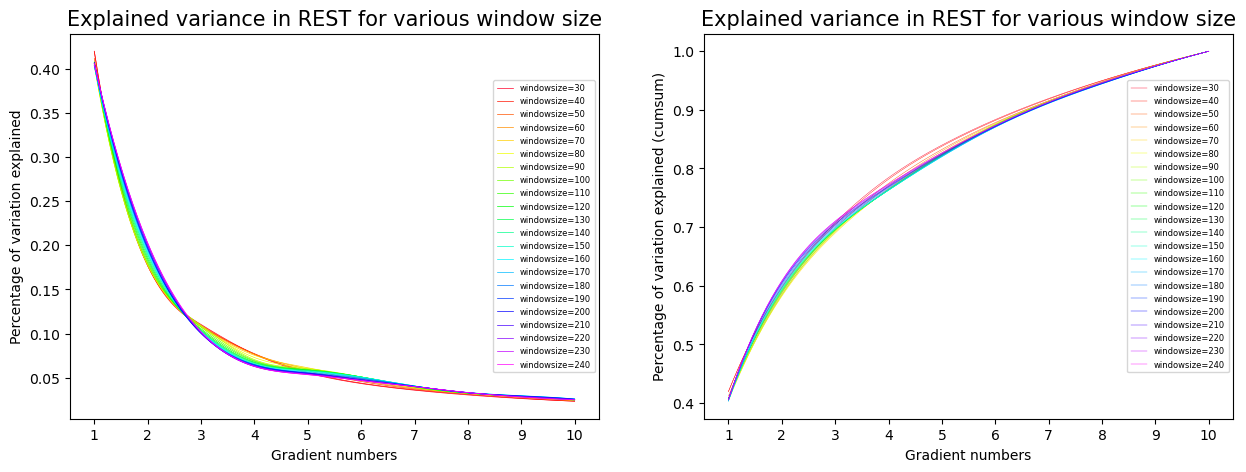

In [8]:
from scipy.interpolate import make_interp_spline

NUM_COLORS = len(stats_var)
cm = plt.get_cmap('gist_rainbow')
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax[1].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(NUM_COLORS):
    y = stats_var[i]/stats_var[i].sum()
    x = np.arange(len(y))
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    ax[0].plot(X_+1,Y_, label='windowsize={}'.format(WS[i]), linewidth = .5)

    y  = np.cumsum(y)
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_, )
    ax[1].plot(X_+1,Y_, label='windowsize={}'.format(WS[i]), linewidth = .3)

for i in range(2):
    ax[i].legend(loc=5, prop={'size': 6})
    ax[i].set_title('Explained variance in REST for various window size', size=15)
    ax[i].set_xlabel('Gradient numbers', size=10)
    if i == 0:
        ax[i].set_ylabel('Percentage of variation explained', size=10)
    else:
        ax[i].set_ylabel('Percentage of variation explained (cumsum)', size=10)

    ax[i].set_xticks(np.arange(1,len(x)+1))

plt.show()

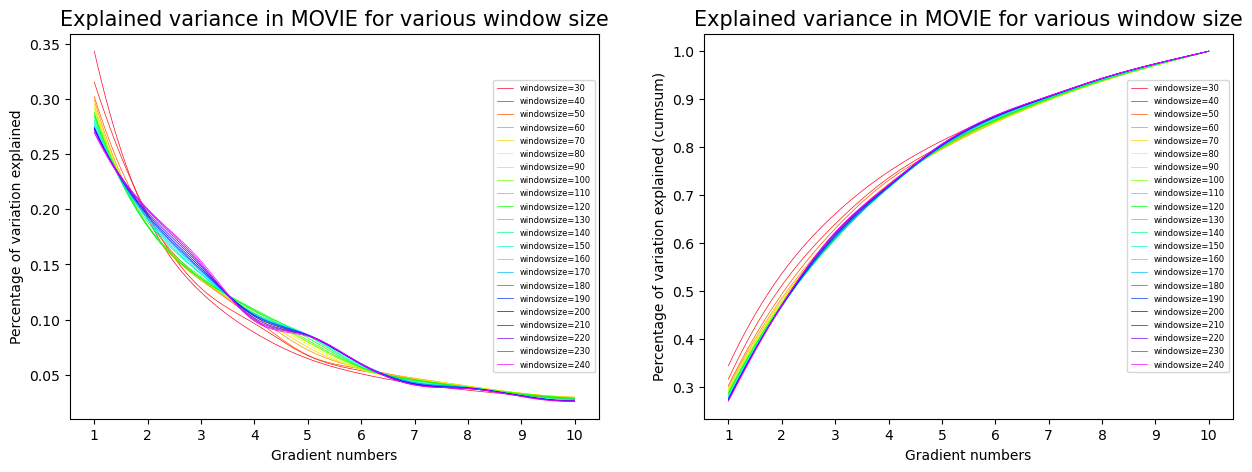

In [9]:
from scipy.interpolate import make_interp_spline

NUM_COLORS = len(stats_var)
cm = plt.get_cmap('gist_rainbow')
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax[1].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in range(NUM_COLORS):
    y = stats_var2[i]/stats_var2[i].sum()
    x = np.arange(len(y))
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    ax[0].plot(X_+1,Y_, label='windowsize={}'.format(WS[i]), linewidth = .5)

    y  = np.cumsum(y)
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_, )
    ax[1].plot(X_+1,Y_, label='windowsize={}'.format(WS[i]), linewidth = .5)

for i in range(2):
    ax[i].legend(loc=5, prop={'size': 6})
    ax[i].set_title('Explained variance in MOVIE for various window size', size=15)
    ax[i].set_xlabel('Gradient numbers', size=10)
    ax[i].set_xticks(np.arange(1,len(x)+1))
    if i == 0:
        ax[i].set_ylabel('Percentage of variation explained', size=10)
    else:
        ax[i].set_ylabel('Percentage of variation explained (cumsum)', size=10)
plt.show()

<a class="anchor" id="visualization"></a>
## "Non-dynamic" dynamic gradient plot

In [4]:
moviename  = "Sintel" 
rest_grad  = load('./resources/dynamic_grad/group_level414/Rest_40_grad.pkl')[0][:,:,:3]
movie_grad = load('./resources/dynamic_grad/group_level414/{}_40_grad.pkl'.format(moviename))[0][:,:,:3]

aligned, ref, score = procrustes_align(np.concatenate([rest_grad,movie_grad]))
rest_grad  = np.asarray(aligned)[:rest_grad.shape[0]]
movie_grad = np.asarray(aligned)[rest_grad.shape[0]:]

rest1  = rest_grad[:,:,0]
rest2  = rest_grad[:,:,1]
movie1 = movie_grad[:,:,0]
movie2 = movie_grad[:,:,1]

100%|██████████| 414/414 [01:29<00:00,  4.64it/s]


(-20.0, 20.0)

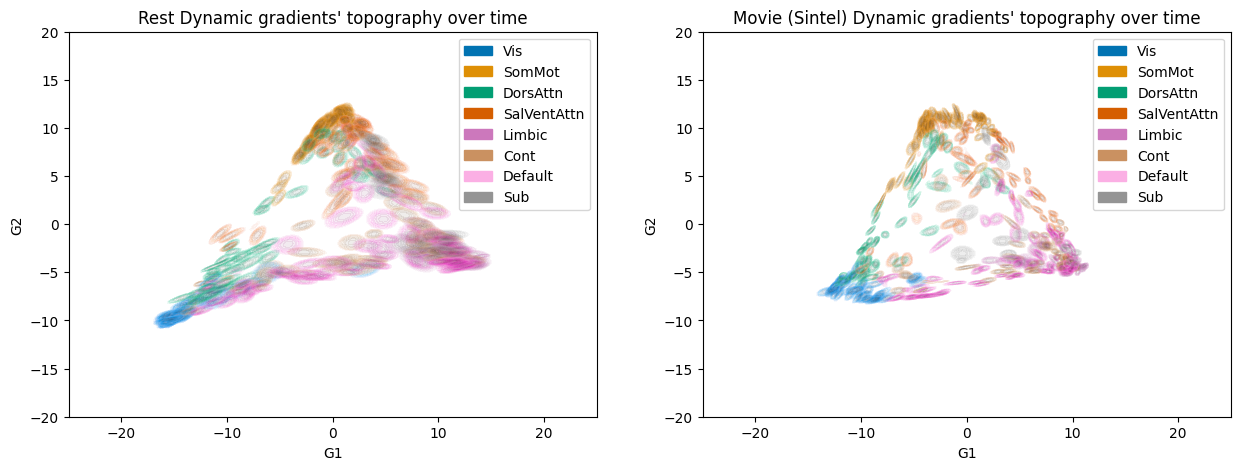

In [5]:
pal = sns.color_palette('colorblind', 8)

partial_region = load('./resources/region414yeo7.pkl')
region_partial = load('./resources/yeo7region414.pkl')
colormapnet    = {key: pal[i] for i,key in enumerate(region_partial.keys())}
coloring       = [colormapnet[partial_region[i]] for i in range(414)]

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=colormapnet[k], label=k) for k in colormapnet.keys()]

fig, ax = plt.subplots(1,2, figsize=(15,5))
for k in tqdm(range(414)):
    df = {'G1': rest1[:,k], 'G2': rest2[:,k]}
    sns.kdeplot(data=df, x="G1", y="G2", fill=True, color=coloring[k], alpha=0.1, thresh=0.95, ax=ax[0])
ax[0].set_title('Rest Dynamic gradients\' topography over time')
ax[0].legend(handles=handles)
ax[0].set_xlim(-25,25)
ax[0].set_ylim(-20,20)

for k in tqdm(range(414)):
    df = {'G1': movie1[:,k], 'G2': movie2[:,k]}
    sns.kdeplot(data=df, x="G1", y="G2", fill=True, color=coloring[k], alpha=0.1, thresh=0.95, ax=ax[1])
ax[1].set_title('Movie ({}) Dynamic gradients\' topography over time'.format(moviename))
ax[1].legend(handles=handles)
ax[1].set_xlim(-25,25)
ax[1].set_ylim(-20,20)

In [6]:
rest_motion  = np.zeros((rest_grad.shape[1], len(rest_grad)))
movie_motion = np.zeros((movie_grad.shape[1], len(movie_grad)))

for r in range(rest_grad.shape[1]):
    rest_motion[r]  = [points_distance(rest_grad[0,r,:,], rest_grad[i,r,:],pmethod='L2') 
                      for i in range(len(rest_grad))]
    
for r in range(rest_grad.shape[1]):
    movie_motion[r] = [points_distance(movie_grad[0,r,:,], movie_grad[i,r,:],pmethod='L2') 
                       for i in range(len(movie_grad))]    

In [7]:
yeo2region = load('./resources/yeo7region414.pkl')
networks   = list(yeo2region.keys())

df = {"score": [], "cond": [], 'network': []}
for n in networks:

    df['score']   += list(rest_motion[yeo2region[n]].std(axis=1))
    df['score']   += list(movie_motion[yeo2region[n]].std(axis=1))
    df['cond']    += ['rest'] * len(yeo2region[n])
    df['cond']    += ['movie'] * len(yeo2region[n])
    df['network'] += [n] * 2 * len(yeo2region[n])
    
df     = pd.DataFrame.from_dict(df)

# Performing two-way ANOVA
model  = ols('score ~ C(cond) + C(network) +\
C(cond):C(network)',
            data=df).fit()
result = sm.stats.anova_lm(model, type=2)

print(result.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &     df &       sum\_sq &      mean\_sq &            F &         PR(>F) \\
\midrule
C(cond)            &    1.0 &  1001.248573 &  1001.248573 &  1254.574036 &  6.964912e-167 \\
C(network)         &    7.0 &    63.845490 &     9.120784 &    11.428430 &   7.002431e-14 \\
C(cond):C(network) &    7.0 &    51.642133 &     7.377448 &     9.244012 &   4.886300e-11 \\
Residual           &  812.0 &   648.039748 &     0.798079 &          NaN &            NaN \\
\bottomrule
\end{tabular}



#### Visualizing interaction factors

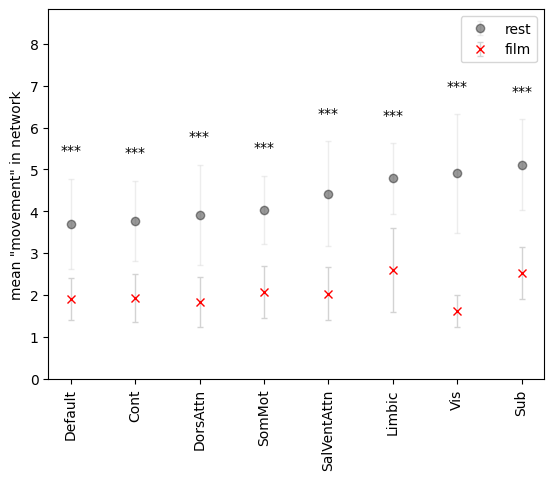

In [9]:
# plot of scatter
rest_df  = df[df.cond == 'rest']
movie_df = df[df.cond == 'movie']
rest_arr  = []
movie_arr = []
for n in networks:
    cur = np.array(rest_df[rest_df.network==n]['score'])
    rest_arr.append([cur.mean(), cur.std()])
    
    cur = np.array(movie_df[movie_df.network==n]['score'])
    movie_arr.append([cur.mean(), cur.std()])
    
rest_arr  = np.asarray(rest_arr)
movie_arr = np.asarray(movie_arr)
order     = np.argsort(rest_arr[:,0])
rest_arr  = rest_arr[order]
movie_arr = movie_arr[order]

plt.errorbar(list(range(rest_arr.shape[0])), rest_arr[:,0], yerr=rest_arr[:,1], fmt='o', color='black',
             ecolor='lightgray', elinewidth=1, capsize=2, alpha=0.4, label='rest');

plt.errorbar(list(range(movie_arr.shape[0])), movie_arr[:,0], yerr=movie_arr[:,1], fmt='x', color='red',
             ecolor='lightgray', elinewidth=1, capsize=2, label='film');

# two-sample t-test
import scipy.stats as stats

lheight = []
for idx,n in enumerate(np.array(networks)[order]):
    pval = stats.ttest_ind(a=np.array(rest_df[rest_df.network==n]['score']), 
                    b=np.array(movie_df[movie_df.network==n]['score'])
                    , equal_var=True).pvalue
    c1, c2, c3 = int(pval < 0.01), int(pval < 0.005), int(pval < 0.001) 
    nbstars = c1 + c2 + c3
    height  = max(rest_arr[idx,0] + rest_arr[idx,1],
                  movie_arr[idx,0] + movie_arr[idx,1]) + 0.5
    lheight.append(height)
    plt.text(idx, height, 
             '*' * nbstars, ha='center', va='bottom')
    
    
plt.ylabel('mean "movement" in network')
# plt.xlabel('networks/regions')
plt.xticks(list(range(rest_arr.shape[0])), 
           np.array(networks)[order], rotation=90)
plt.ylim(0,max(lheight) + 2)
plt.legend()
plt.show()
